<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/Prova_1%20-%20IE345P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prova 1 - Introduction to Fundamentals of Deep Learning for Cloud, Mobile and Edge using Python, Keras and TensorFlow.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

import math
import numpy as np

Download ***flower_photos*** dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 6s 0us/step


In [3]:
batch_size = 32
img_height = 224
img_width = 224

Define train and val sets

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # % of data left for the val set
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # % of data left for the val set
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
# normalize 
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in [0,1].
print(np.min(first_image), np.max(first_image))

0.0 1.0


How many classes are in the dataset?

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Define the model

In [9]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [10]:
def model_maker():
    base_model = MobileNet(include_top=False,
                           input_shape=(img_width, img_height, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(img_width, img_height, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [11]:
NUM_CLASSES = 5
model = model_maker()
model.compile(
  #optimizer='adam',
  optimizer=tf.keras.optimizers.Adam(0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

17227776/17225924 [==============================] - 1s 0us/step


In [12]:
model.fit_generator(
    train_ds,
    steps_per_epoch=math.ceil(float(2936) / batch_size),
    epochs=25,
    validation_data=val_ds,
    validation_steps=math.ceil(float(734) / batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
92/92 [==============================] - 19s 203ms/step - loss: 1.5401 - accuracy: 0.3512 - val_loss: 1.2707 - val_accuracy: 0.5286
Epoch 2/25
92/92 [==============================] - 16s 179ms/step - loss: 1.2722 - accuracy: 0.4850 - val_loss: 1.1058 - val_accuracy: 0.5940
Epoch 3/25
92/92 [==============================] - 16s 179ms/step - loss: 1.1735 - accuracy: 0.5364 - val_loss: 1.0425 - val_accuracy: 0.6104
Epoch 4/25
92/92 [==============================] - 17s 187ms/step - loss: 1.1145 - accuracy: 0.5490 - val_loss: 1.0025 - val_accuracy: 0.6376
Epoch 5/25
92/92 [==============================] - 16s 178ms/step - loss: 1.0500 - accuracy: 0.5960 - val_loss: 0.9461 - val_accuracy: 0.6689
Epoch 6/25
92/92 [==============================] - 16s 177ms/step - loss: 1.0118 - accuracy: 0.6022 - val_loss: 0.9065 - val_accuracy: 0.6689
Epoch 7/25
92/92 [==============================] - 17s 181ms/step

In [13]:
model.save('/content/model.h5')

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model = load_model('model.h5')

In [16]:
# Here you need to upload the test.zip file

from zipfile import ZipFile
file_name = "test.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Necessary functions for predicting data

In [17]:
import os
from tensorflow.keras.preprocessing import image
img_path = '/content/test'

def predict(img_path): 
  predictions = [] 
  label_order = []
  for file in os.listdir(img_path):
    e = str(file)
    dum = ''
    path = img_path + '/' + file
    for j in range(len(e)):
      if e[j]!= '.':
        dum += e[j]
      else:
        break
    label_order.append(dum)
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = expanded_img_array #/ 255.  # Preprocess the image
    prediction = model.predict(preprocessed_img)
    predictions.append(np.asarray(prediction))
  
  return np.vstack(np.asarray(predictions)),label_order
  
      


In [18]:
import matplotlib.pyplot as plt

def test_out(img_path, class_names,predicted_classes):
  
  plt.figure(figsize=(20, 20))
  i = 0
  for images in os.listdir(img_path):
    #print(images)
    path = img_path + '/' + images
    ax = plt.subplot(10,4 , i + 1)
    ig = plt.imread(path)
    plt.imshow(ig)
    plt.title(class_names[predicted_classes[i]])
    plt.axis("off")
    i = i+1


Now let's test our model

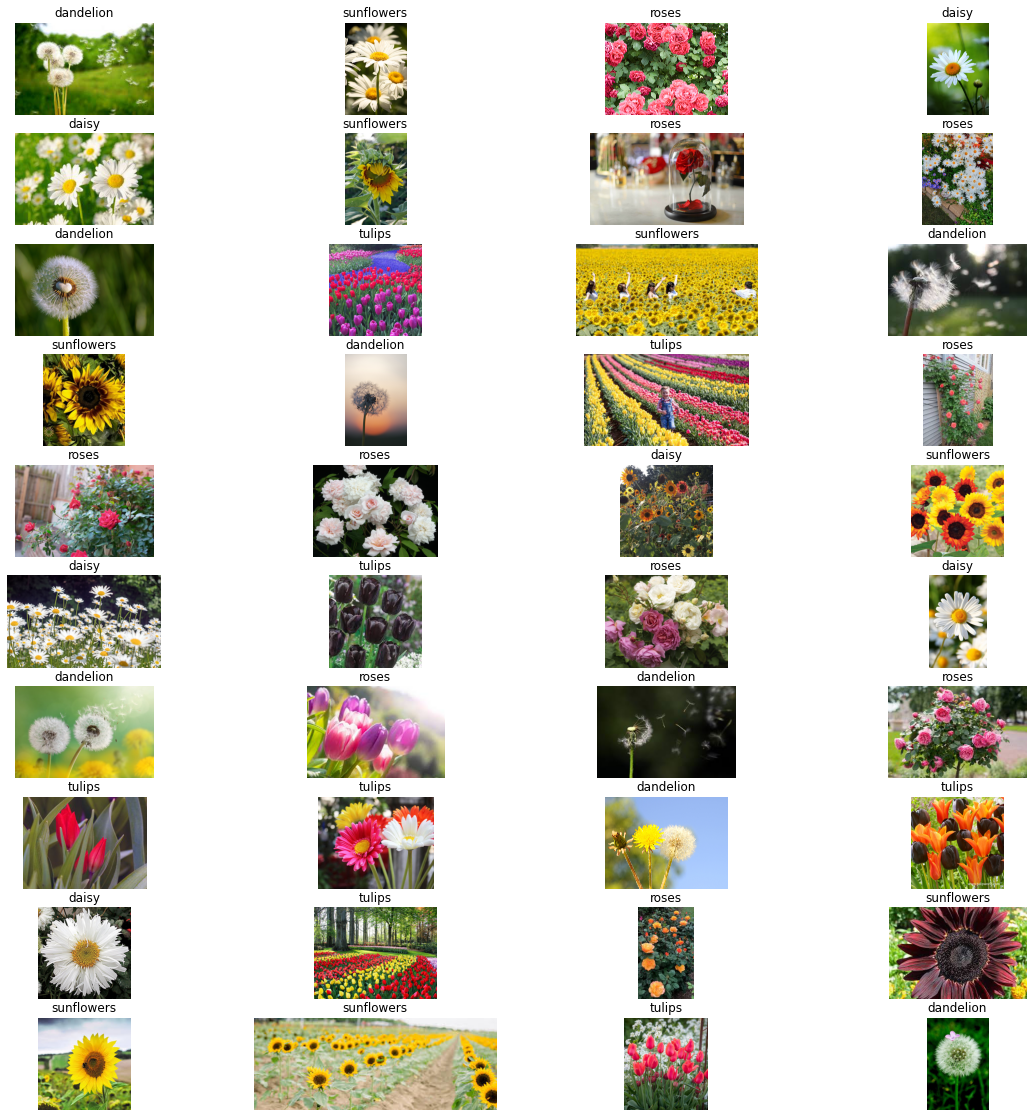

In [19]:
predictions,labelo = predict(img_path)
# Generate arg maxes for predictions
predicted_classes = np.argmax(predictions, axis=1)

test_out(img_path, class_names, predicted_classes)


Now we can visualize our predicted data

In [20]:
# create dictionary
dct = {0:class_names[0],1:class_names[1],
       2:class_names[2],3:class_names[3],
       4:class_names[4]}

lbl_order = (np.asarray(labelo)).astype(np.int)

pred_lbl = np.vstack((predicted_classes,lbl_order))

test_pred = np.empty(40, dtype='object')

for i in pred_lbl[1]:
  dnd = np.where(pred_lbl == i)
  clm = dnd[1][0]
  test_pred[i-1] = dct[predicted_classes[clm]]

test_pred = np.hstack(test_pred)
print("Predictions made over the test set:\n\n", test_pred)

Predictions made over the test set:

 ['dandelion' 'roses' 'sunflowers' 'tulips' 'dandelion' 'roses'
 'sunflowers' 'tulips' 'dandelion' 'roses' 'sunflowers' 'tulips' 'roses'
 'sunflowers' 'tulips' 'dandelion' 'dandelion' 'roses' 'sunflowers'
 'tulips' 'daisy' 'roses' 'daisy' 'sunflowers' 'tulips' 'roses'
 'dandelion' 'roses' 'sunflowers' 'daisy' 'roses' 'sunflowers' 'tulips'
 'dandelion' 'tulips' 'dandelion' 'roses' 'tulips' 'sunflowers' 'roses']


In [21]:
import pandas as pd

read_labels = pd.read_csv('test_labels.txt', header = None)
test_labels = np.squeeze(np.asarray(read_labels))
print("True labels for our test set:\n\n",test_labels)


True labels for our test set:

 ['daisy' 'daisy' 'dandelion' 'daisy' 'dandelion' 'roses' 'sunflowers'
 'tulips' 'dandelion' 'roses' 'sunflowers' 'tulips' 'roses' 'sunflowers'
 'tulips' 'dandelion' 'dandelion' 'roses' 'sunflowers' 'tulips' 'daisy'
 'roses' 'sunflowers' 'daisy' 'tulips' 'daisy' 'dandelion' 'roses'
 'sunflowers' 'daisy' 'roses' 'sunflowers' 'tulips' 'dandelion' 'daisy'
 'dandelion' 'roses' 'tulips' 'sunflowers' 'tulips']


In [22]:
# comparing predicted labels vs real labels and obtainin how many images where wrong predicted

img_err = 0
for i in range(test_labels.shape[0]):
  a = test_labels[i]
  b = test_pred[i]
  if a != b: 
    img_err = img_err + 1

print("Number of errors in prediction:", img_err)

Number of errors in prediction: 9


### HERE GOES YOUR CODE (for questions 1 and 2)

In [ ]:
# The np.array that has predicted values
#test_pred
# The np.array that has real values
#test_labels

In [67]:
cont_miss, cont_hit = 0, 0
miss_labels = []
hit_labels = []

for i in range(0,len(test_pred)):
  if test_pred[i] != test_labels[i]:
    cont_miss+=1
    miss_labels.append(test_labels[i])
  else:
    cont_hit+=1
    hit_labels.append(test_labels[i])
print('Miss Labels: ', cont_miss)
print('\n', miss_labels)
print('Correct pred labels: ', cont_hit)
print('\n', hit_labels)

Miss Labels:  9

 ['daisy', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'daisy', 'daisy', 'daisy', 'tulips']
Correct pred labels:  31

 ['dandelion', 'roses', 'sunflowers', 'tulips', 'dandelion', 'roses', 'sunflowers', 'tulips', 'roses', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'tulips', 'daisy', 'roses', 'tulips', 'dandelion', 'roses', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'roses', 'tulips', 'sunflowers']


In [68]:
# Best and worst predicted class
from collections import Counter
names = miss_labels
c = Counter(names)
print('Worst predictions:') 
print(c)
print('Worst predicted class: ', c.most_common()[0][0])

names = hit_labels
c = Counter(names)
print('\n\nBest predictions:') 
print(c)
print('Best predicted class: ', c.most_common()[0][0])

Worst predictions:
Counter({'daisy': 6, 'dandelion': 1, 'sunflowers': 1, 'tulips': 1})
Worst predicted class:  daisy


Best predictions:
Counter({'roses': 8, 'dandelion': 7, 'sunflowers': 7, 'tulips': 7, 'daisy': 2})
Best predicted class:  roses


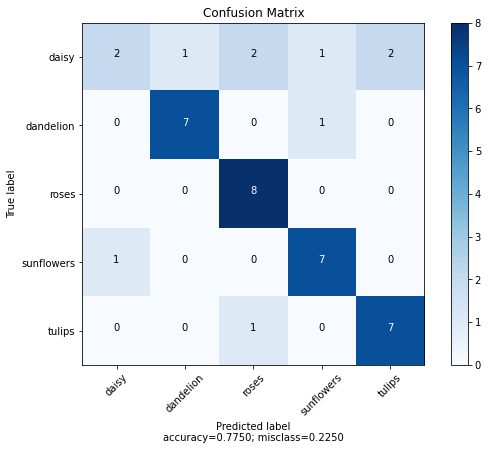

In [64]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_true = test_labels
y_pred = test_pred
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm, class_names, 'Confusion Matrix')